In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col
import time

# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()


23/12/14 17:46:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
# Define the schema for our data
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

In [3]:
transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))

query = transactions.writeStream \
.format("memory") \
.queryName("temporary_view_three") \
.start()

query.awaitTermination(30)



23/12/14 17:46:49 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-81483a26-b865-4339-a4ed-0c343e215de9. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/14 17:46:49 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/14 17:46:52 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [4]:
processed_data = spark.sql("SELECT * FROM temporary_view_three")

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

transactions = processed_data.withColumn("transaction_amount", col("transaction_amount").cast(DoubleType()))

In [6]:
transactions.show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|       Phoenix|2023-12-14 17:46:54|    P00071|            -537.0|
|   San Antonio|2023-12-14 17:46:57|    P00084|             134.0|
|       Phoenix|2023-12-14 17:46:58|    P00006|             750.0|
|       Chicago|2023-12-14 17:47:00|    P00018|             378.0|
|  Philadelphia|2023-12-14 17:47:03|    P00058|             128.0|
|       Houston|2023-12-14 17:47:05|    P00014|             318.0|
|   San Antonio|2023-12-14 17:47:08|    P00014|             368.0|
|   San Antonio|2023-12-14 17:47:11|    P00018|             489.0|
|   Los Angeles|2023-12-14 17:47:13|    P00011|             105.0|
|       Chicago|2023-12-14 17:47:15|    P00057|              29.0|
|       Chicago|2023-12-14 17:47:17|    P00068|             628.0|
|   Los Angeles|2023-12-14 17:47:19|    P00031|             88

In [7]:
from pyspark.sql.functions import sum
total_transactions = transactions.groupBy("store_location").agg(sum("transaction_amount").alias("total_amount"))
total_transactions.show()

+--------------+------------+
|store_location|total_amount|
+--------------+------------+
|       Phoenix|       838.0|
|   San Antonio|       991.0|
|  Philadelphia|       128.0|
|   Los Angeles|      1821.0|
|       Chicago|      1035.0|
|       Houston|       318.0|
+--------------+------------+



In [8]:
with_discount = transactions.withColumn("discounted_amount", col("transaction_amount") * 0.9)
with_discount.show()

+--------------+-------------------+----------+------------------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount| discounted_amount|
+--------------+-------------------+----------+------------------+------------------+
|       Phoenix|2023-12-14 17:46:54|    P00071|            -537.0|            -483.3|
|   San Antonio|2023-12-14 17:46:57|    P00084|             134.0|120.60000000000001|
|       Phoenix|2023-12-14 17:46:58|    P00006|             750.0|             675.0|
|       Chicago|2023-12-14 17:47:00|    P00018|             378.0|             340.2|
|  Philadelphia|2023-12-14 17:47:03|    P00058|             128.0|             115.2|
|       Houston|2023-12-14 17:47:05|    P00014|             318.0|             286.2|
|   San Antonio|2023-12-14 17:47:08|    P00014|             368.0|             331.2|
|   San Antonio|2023-12-14 17:47:11|    P00018|             489.0|             440.1|
|   Los Angeles|2023-12-14 17:47:13|    P00011|       

In [9]:
with_discount.filter(with_discount.store_location == 'online').show()

+--------------+----------------+----------+------------------+-----------------+
|store_location|time_of_purchase|product_ID|transaction_amount|discounted_amount|
+--------------+----------------+----------+------------------+-----------------+
+--------------+----------------+----------+------------------+-----------------+



In [10]:
with_discount.filter(with_discount.store_location != 'online').show()

+--------------+-------------------+----------+------------------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount| discounted_amount|
+--------------+-------------------+----------+------------------+------------------+
|       Phoenix|2023-12-14 17:46:54|    P00071|            -537.0|            -483.3|
|   San Antonio|2023-12-14 17:46:57|    P00084|             134.0|120.60000000000001|
|       Phoenix|2023-12-14 17:46:58|    P00006|             750.0|             675.0|
|       Chicago|2023-12-14 17:47:00|    P00018|             378.0|             340.2|
|  Philadelphia|2023-12-14 17:47:03|    P00058|             128.0|             115.2|
|       Houston|2023-12-14 17:47:05|    P00014|             318.0|             286.2|
|   San Antonio|2023-12-14 17:47:08|    P00014|             368.0|             331.2|
|   San Antonio|2023-12-14 17:47:11|    P00018|             489.0|             440.1|
|   Los Angeles|2023-12-14 17:47:13|    P00011|       

There don't seem to be any transactions online no matter how long I run the query for.

In [11]:
import plotly
import plotly.express as px
import pandas as pd


In [17]:
total_transactions_pd = total_transactions.toPandas()
total_transactions_pd


,store_location,total_amount
0,Phoenix,838.0
1,San Antonio,1375.0
2,Philadelphia,128.0
3,Los Angeles,1821.0
4,Chicago,1035.0
5,Houston,319.0


In [ ]:
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

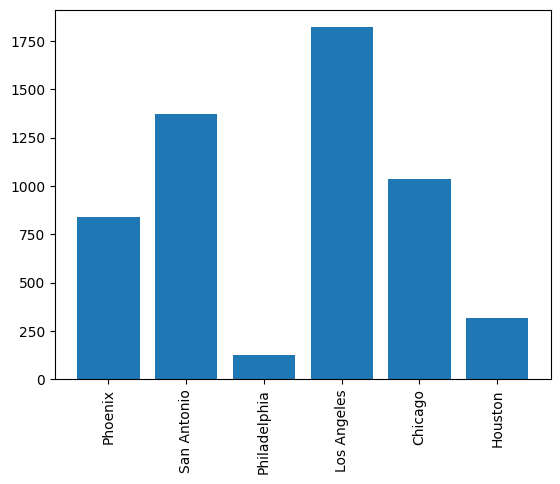

In [27]:
plt.bar(x=total_transactions_pd.store_location, height=total_transactions_pd.total_amount, )
plt.xticks(rotation=90)

In [41]:
total_transactions_per_store = transactions.groupBy('store_location').count().select('store_location', col('count').alias('transaction_count'))
total_transactions_per_store_pd = total_transactions_per_store.toPandas()
total_transactions_per_store_pd

,store_location,transaction_count
0,Phoenix,149
1,San Antonio,130
2,Philadelphia,131
3,Los Angeles,130
4,Chicago,131
5,Houston,149
6,New York,129


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

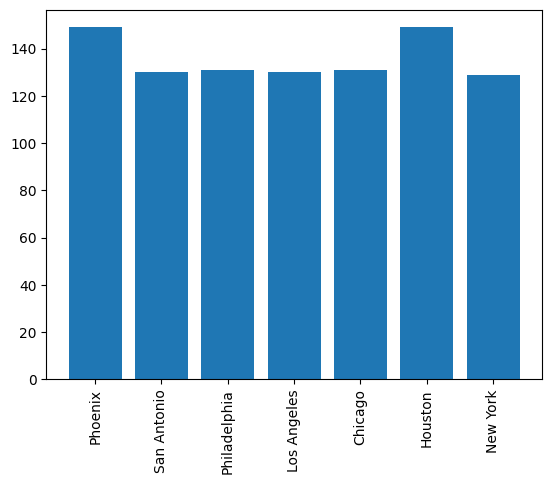

In [44]:
plt.bar(x=total_transactions_per_store_pd.store_location, height=total_transactions_per_store_pd.transaction_count)
plt.xticks(rotation=90)

In [48]:
transactions.orderBy(transactions.transaction_amount.desc()).show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|   Los Angeles|2023-12-14 18:01:07|    P00038|            1000.0|
|  Philadelphia|2023-12-14 18:03:34|    P00040|            1000.0|
|       Chicago|2023-12-14 18:05:13|    P00017|             998.0|
|       Chicago|2023-12-14 17:51:27|    P00054|             996.0|
|       Houston|2023-12-14 18:07:03|    P00011|             996.0|
|       Houston|2023-12-14 18:16:59|    P00015|             995.0|
|       Phoenix|2023-12-14 18:05:35|    P00028|             992.0|
|       Houston|2023-12-14 18:21:30|    P00022|             992.0|
|   San Antonio|2023-12-14 17:47:34|    P00059|             991.0|
|   Los Angeles|2023-12-14 17:58:05|    P00058|             991.0|
|   San Antonio|2023-12-14 18:01:30|    P00042|             991.0|
|  Philadelphia|2023-12-14 18:05:15|    P00050|             99